### Идеи для фичей:
- [x] Как давно началось партнерство
- [x] Кол-во привлеченных клиентов
- [x] Среднее значение и медиана привлеченных клиентов в месяц
- [ ] Отношение привлеченных клиентов за последний месяц к медиане по всем месяцам
- [x] кол-во дней с последнего привлеченного клиента

### Идея для решения
* Кластеризация
* Временные ряды
* Бустинг(сделай фичи, если за последние 1/2/3 месяца не было активности то 1, иначе 0)





## Import


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from collections import defaultdict

from sklearn.cluster import KMeans


## data upload


In [ ]:
path2folder = "/content/drive/MyDrive/Alfa Campus Junior ML_ Материалы"

In [ ]:
data = pd.read_csv(f"{path2folder}/dataset.csv")
sub_example = pd.read_csv(f"{path2folder}/submission_example.csv")

In [ ]:
data.head(5)

,clientbankpartner_pin,client_pin,partner_src_type_ccode,client_start_date,partnerrolestart_date
0,122027,5579,4,2019-06-25,2019-02-01
1,270277,5585,4,2020-05-07,2020-04-01
2,238679,5586,4,2020-02-27,2020-02-01
3,118398,5587,4,2020-03-26,2019-09-01
4,10402,5588,1,2019-04-05,2019-01-01


In [ ]:
sub_example.shape

(4508, 2)

## EDA


In [ ]:
data["clientbankpartner_pin"].value_counts()

clientbankpartner_pin
123986    1790
4054       992
125042     915
130756     746
178935     684
          ... 
121828       1
282232       1
129606       1
136806       1
332692       1
Name: count, Length: 9471, dtype: int64

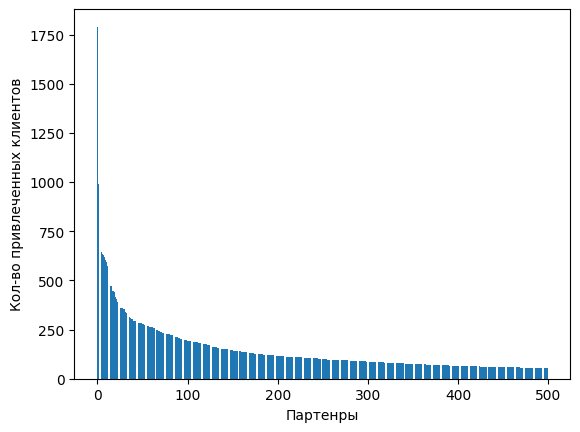

In [ ]:
# x = data["clientbankpartner_pin"].value_counts().index.tolist()
y = data["clientbankpartner_pin"].value_counts().to_numpy()[:500]
plt.bar(x=range(0, len(y)), height=y)
plt.xlabel("Партенры")
plt.ylabel("Кол-во привлеченных клиентов")
plt.show()

In [ ]:
data[data["clientbankpartner_pin"] == 1]

,clientbankpartner_pin,client_pin,partner_src_type_ccode,client_start_date,partnerrolestart_date,days_after_partnership,clients_count,average_clients_per_month,last_client_date
10756,1,31215,5,2020-09-15,2019-08-01,488,6,0.5,183
24556,1,55860,5,2020-10-28,2019-08-01,488,6,0.5,183
36833,1,118041,5,2020-11-25,2019-08-01,488,6,0.5,183
68163,1,211585,5,2019-11-24,2019-08-01,488,6,0.5,183
107826,1,291300,5,2020-05-29,2019-08-01,488,6,0.5,183
119185,1,312159,5,2020-06-05,2019-08-01,488,6,0.5,183


  client_start_date  counts
0        2019-11-24       1
1        2020-05-29       1
2        2020-06-05       1
3        2020-09-15       1
4        2020-10-28       1
5        2020-11-25       1


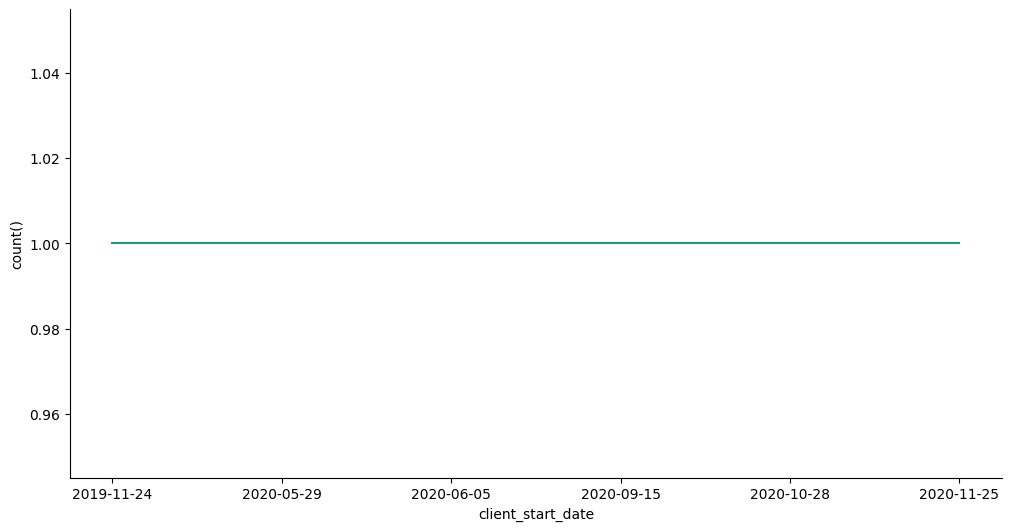

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['client_start_date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'client_start_date'}, axis=1)
              .sort_values('client_start_date', ascending=True))
  xs = counted['client_start_date']
  ys = counted['counts']
  print(counted)
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# df_sorted = data.sort_values('client_start_date', ascending=True)
df_sorted = data[data["clientbankpartner_pin"] == 1].sort_values('client_start_date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('client_start_date')
_ = plt.ylabel('count()')

In [ ]:
train_parts_pins = data["clientbankpartner_pin"].unique()
pred_parts_pins = sub_example["clientbankpartner_pin"].unique()
print(len(pred_parts_pins), len(set(train_parts_pins).intersection(set(pred_parts_pins)))) # по всем партнерам для предсказания есть инфа

4508 4508


In [ ]:
dates = pd.to_datetime(data["client_start_date"])
first_date = datetime.datetime.date(dates.sort_values()[0])
last_date = datetime.datetime.date(dates.sort_values()[1])
print(first_date, last_date)

2019-06-25 2020-05-07


## Data preparation


In [ ]:
data

,clientbankpartner_pin,client_pin,partner_src_type_ccode,client_start_date,partnerrolestart_date
0,122027,5579,4,2019-06-25,2019-02-01
1,270277,5585,4,2020-05-07,2020-04-01
2,238679,5586,4,2020-02-27,2020-02-01
3,118398,5587,4,2020-03-26,2019-09-01
4,10402,5588,1,2019-04-05,2019-01-01
...,...,...,...,...,...
130813,4639,333509,5,2020-07-20,2020-03-01
130814,226754,333510,4,2020-07-19,2020-05-01
130815,2645,333511,5,2020-07-23,2020-05-01
130816,145720,333512,1,2020-07-25,2019-05-01


In [ ]:
partners_clients_all_month

,clientbankpartner_pin,client_start_date
0,1,"[2020-09-15, 2020-10-28, 2020-11-25, 2019-11-2..."
1,2,"[2019-06-13, 2019-11-27, 2020-09-10, 2020-09-2..."
2,5,"[2019-08-16, 2019-09-02, 2019-10-04, 2019-12-2..."
3,6,[2019-09-30]
4,9,"[2019-12-29, 2020-01-21]"
...,...,...
9466,333438,[2020-11-20]
9467,333459,"[2020-08-03, 2020-10-20]"
9468,333492,"[2020-09-17, 2020-08-20]"
9469,333511,"[2020-07-30, 2020-08-03, 2020-08-09, 2020-08-1..."


In [ ]:
clients_count_data = data.groupby("clientbankpartner_pin")["client_pin"].count().reset_index()  # Кол-во клиентов для каждого партнера
last_client_date_data = data.groupby("clientbankpartner_pin")["client_start_date"].apply(lambda x: (datetime.date(day=1, month=12, year=2020) - datetime.date(day=1, month=int(list(x)[-1].split('-')[1]), year=int(list(x)[-1].split('-')[0]))).days).reset_index()  # Количество дней после последнего клиента
partners_clients_all_month = data.groupby("clientbankpartner_pin")["client_start_date"].apply(lambda x: list(x)).reset_index()  # Спикок дат приведения клиента для каждого парнера

def average_clients_per_month(dates):
    dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

    dates.sort()
    monthly_clients = defaultdict(int)
    for date in dates:
        monthly_clients[(date.year, date.month)] += 1
    k_months = (datetime.date(day=1, month=dates[-1].month, year=dates[-1].year) - datetime.date(day=1, month=dates[0].month, year=dates[0].year)).days // 30
    if k_months == 0:
        res = sum(monthly_clients.values())
    else:
        res = sum(monthly_clients.values()) / k_months
    return res

average_clients_per_month_data = data.groupby("clientbankpartner_pin")["client_start_date"].apply(lambda x: average_clients_per_month(list(x))).reset_index()


def clients_count(x):
    return clients_count_data[clients_count_data["clientbankpartner_pin"] == x].values[0][1]


def get_avg_clients(x):
    return average_clients_per_month_data[average_clients_per_month_data["clientbankpartner_pin"] == x].values[0][1]


def last_client_data(x):
    return last_client_date_data[last_client_date_data["clientbankpartner_pin"] == x].values[0][1]

def get_target(x):
    x_dates = partners_clients_all_month[partners_clients_all_month["clientbankpartner_pin"] == x].values[0][1]
    for date in x_dates:
        if pd.to_datetime(date) >= pd.Timestamp(day=1, month=9, year=2020):
            return 1
    return 0

def get_month_clients(x):
    dates = [datetime.date(2019, 6, 25), datetime.date(2019, 7, 25), datetime.date(2019, 8, 25), datetime.date(2019, 9, 25), datetime.date(2019, 10, 25), datetime.date(2019, 11, 25), datetime.date(2019, 12, 25), datetime.date(2020, 1, 25), datetime.date(2020, 2, 25), datetime.date(2020, 3, 25), datetime.date(2020, 4, 25), datetime.date(2020, 5, 25)]
    d = defaultdict(int)
    for date in dates:
        for date_2 in partners_clients_all_month[partners_clients_all_month["clientbankpartner_pin"] == x["clientbankpartner_pin"]].values[0][1]:
            year_2 = int(date_2.split("-")[0])
            month_2 = int(date_2.split("-")[1])
            if date.year == year_2 and date.month == month_2:
                d[(date.year, date.month)] += 1
            else:
                d[(date.year, date.month)] += 0

    return list(d.values())

def prep(df, target=False):  # Предобработка для кластеризации и бустинга
    print("Processing: 0%")
    df = df.drop(columns=["client_pin", "client_start_date"])
    print("Processing: 13%")
    df["partnerrolestart_date"] = pd.to_datetime(df["partnerrolestart_date"])
    print("Processing: 26%")
    df["days_after_partnership"] = (pd.to_datetime(datetime.date(day=1, month=12, year=2020)) - df["partnerrolestart_date"]).dt.days # дней с момента начала партнерства
    print("Processing: 39%")
    df["clients_count"] = df["clientbankpartner_pin"].apply(clients_count)  # Кол-во привлеченных клиентов
    print("Processing: 51%")
    df["average_clients_per_month"] = df["clientbankpartner_pin"].apply(get_avg_clients)  # Среднее кол-во клиентов в месяц
    print("Processing: 70%")
    df["last_client_date"] = df["clientbankpartner_pin"].apply(last_client_data)  # Дней с привлечения последнего клиента
    print("Processing: 86%")
    if target == True:
        df["target"] = df["clientbankpartner_pin"].apply(get_target)
    print("Processing: 100%")
    return df

def prep4time_series(df):  # Предобратока для временных рядов
    dates = [first_date]
    while dates[-1] <= last_date:
        dates.append(dates[-1] + relativedelta(months=1))
    new_dates = []
    for date in dates:
        df[f"{date.year}-{date.month}"] = 0
        new_dates.append(f"{date.year}-{date.month}")

    df[new_dates] = list(df.apply(get_month_clients, axis=1))
    return df


In [ ]:
x = prep(data, target=True)

1
2
3
4
5
6
7


KeyboardInterrupt: 

In [ ]:
x.head(5)

In [ ]:
# series_x.to_csv("series_x.csv", index=False)
x.to_csv(f"{path2folder}/train_data.csv", index=False)

In [ ]:
features = ["partner_src_type_ccode", "days_after_partnership", "clients_count", "average_clients_per_month", "last_client_date"]


In [ ]:
x.head(5)

,clientbankpartner_pin,client_pin,partner_src_type_ccode,client_start_date,partnerrolestart_date,days_after_partnership,clients_count,average_clients_per_month,last_client_date
0,122027,5579,4,2019-06-25,2019-02-01,669,113,6.647059,153
1,270277,5585,4,2020-05-07,2020-04-01,244,473,67.571429,122
2,238679,5586,4,2020-02-27,2020-02-01,304,6,0.666667,183
3,118398,5587,4,2020-03-26,2019-09-01,457,192,21.333333,183
4,10402,5588,1,2019-04-05,2019-01-01,700,371,30.916667,275


## Clusterization model

### KMeans

In [ ]:
x["score"] = KMeans(n_clusters=2, random_state=42, n_init="auto").fit_predict(x[features])

In [ ]:
sub_example.drop_duplicates(subset='clientbankpartner_pin', inplace=True)
x.drop_duplicates(subset='clientbankpartner_pin', inplace=True)

merged_df = pd.merge(sub_example.drop(columns=["score"]), x[["clientbankpartner_pin"] + features + ["score"]], on='clientbankpartner_pin', how="left")

In [ ]:
merged_df[["clientbankpartner_pin", "score"]].to_csv("clast_sub_1.csv", index=False)

## Time series model


### Arima

In [ ]:
series_x

,clientbankpartner_pin,client_pin,partner_src_type_ccode,client_start_date,partnerrolestart_date,2019-6,2019-7,2019-8,2019-9,2019-10,2019-11,2019-12,2020-1,2020-2,2020-3,2020-4,2020-5
0,122027,5579,4,2019-06-25,2019-02-01,8,4,5,3,17,9,1,0,2,1,3,0
1,270277,5585,4,2020-05-07,2020-04-01,0,0,0,0,0,0,0,0,0,0,7,67
2,238679,5586,4,2020-02-27,2020-02-01,0,0,0,0,0,0,0,0,1,0,1,0
3,118398,5587,4,2020-03-26,2019-09-01,0,0,0,12,9,25,23,31,21,11,23,30
4,10402,5588,1,2019-04-05,2019-01-01,40,22,15,7,14,5,19,18,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130813,4639,333509,5,2020-07-20,2020-03-01,0,0,0,0,0,0,0,0,0,2,7,5
130814,226754,333510,4,2020-07-19,2020-05-01,0,0,0,0,0,0,0,0,0,0,0,21
130815,2645,333511,5,2020-07-23,2020-05-01,0,0,0,0,0,0,0,0,0,0,0,3
130816,145720,333512,1,2020-07-25,2019-05-01,2,0,2,0,2,0,4,5,9,6,6,15


In [ ]:
series_x[series_x["clientbankpartner_pin"] == id].drop(columns=["clientbankpartner_pin", "client_pin", "partner_src_type_ccode", "client_start_date", "partnerrolestart_date"]).drop_duplicates()

,2019-6,2019-7,2019-8,2019-9,2019-10,2019-11,2019-12,2020-1,2020-2,2020-3,2020-4,2020-5
9,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
for id in sub_example["clientbankpartner_pin"].unique():
    # Assuming you're selecting a single column for the time series
    series = series_x[series_x["clientbankpartner_pin"] == id].drop(columns=["clientbankpartner_pin", "client_pin", "partner_src_type_ccode", "client_start_date", "partnerrolestart_date"]).drop_duplicates()
    print(type(series))
    model = ARIMA(series, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=3)
    print(forecast)

<class 'pandas.core.frame.DataFrame'>


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: SARIMAX models require univariate `endog`. Got shape (1, 12).

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


# group by id and resample to monthly frequency
# df_monthly = df.resample('M', on='date').sum().reset_index()

# create a list to store the predictions for each partner
predictions = []

# loop through each partner
for partner_id in ser['clientbankpartner_pin'].unique():

    # get the time series data for the current partner
    partner_data = df_monthly[df_monthly['id'] == partner_id].set_index('date')['clients']

    # fit the ARIMA model
    model = ARIMA(partner_data, order=(1,1,1))
    model_fit = model.fit()

    # forecast for the next 3 months
    forecast = model_fit.forecast(steps=3)

    # append the forecast to the predictions list
    predictions.append(forest)

# create a dataframe with the predictions
predictions_df = pd.DataFrame({'id': np.repeat(df_monthly['id'].unique(), 3),
                               'date': pd.date_range(end=df_monthly['date'].max(), periods=3*len(df_monthly['id'].unique()), freq='M'),
                               'forecast': np.concatenate(predictions)})

# merge the predictions with the original data
result_df = pd.merge(df_monthly, predictions_df, on=['id', 'date'], how='outer')

NameError: name 'ser' is not defined

## Boosting

### Catboost

### data processing